## LEGO Brick Classifier

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
import pickle


from PIL import Image
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image

In [ ]:
!pip install gradio
!pip install pyttsx3
!sudo apt install espeak #Install espeak text-to-speech engine
!sudo apt install espeak-ng

# Importing Data

In [4]:

# Upload a ZIP File and Extract
from google.colab import files
uploaded = files.upload()

Saving data_modify.zip to data_modify.zip


In [372]:

# Unzip the file

import zipfile
import imghdr

zip_file = "data_modify.zip"  # Change to your filename
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("/content/images")  # Extract to 'images' folder



In [373]:
#Load images


image_folder = "/content/images/data_modify"
images = []


# Load images only if they are valid image files
for filename in os.listdir(image_folder):
    file_path = os.path.join(image_folder, filename)

    # Check if the file is a valid image
    if os.path.isfile(file_path):
        # Check if the file is a valid image
        if imghdr.what(file_path):
            img = Image.open(file_path)  # Open the image using PIL

             #black back ground to white
            #image_array = np.array(img)
            #black_pixels = (image_array[:, :, :3] == 0).all(axis=-1)
            #image_array[black_pixels] = [255, 255, 255]
            #img = Image.fromarray(image_array)

            images.append(img)

print(f"Loaded {len(images)} images")




Loaded 1136 images


## Pickling the images

In [ ]:
"""
# Mount the images to the drive

drive.mount('/content/drive')

# Open a new file named 'img.pkl' with write permission
with open('/content/drive/My Drive/img.pkl', 'wb') as file:
    # Use pickle.dump to store the list of images
    pickle.dump(images, file)

    """

Mounted at /content/drive


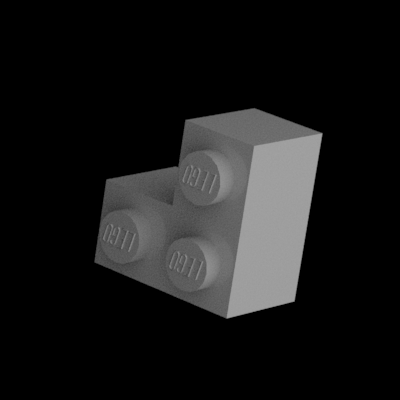

In [ ]:
# Load the images from the pkl file
with open('/content/drive/My Drive/img.pkl', 'rb') as file:
    images = pickle.load(file)

images[800]

In [7]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
from tensorflow.keras.models import load_model
# Re-load model
model1 = keras.models.load_model('/content/drive/MyDrive/model1_27.keras')
model2 = keras.models.load_model('/content/drive/MyDrive/model2.keras')
model3 = keras.models.load_model('/content/drive/MyDrive/model3_v1.0.keras')

# Extract the file names

In [374]:
# Create a dataframe to store the file names from Images

file_names = []
# Walk through the directory and get all image filenames
for root, _, files in os.walk(image_folder):
    for filename in files:
        file_path = os.path.join(root, filename)

        # Append only image files
        if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
            file_names.append({"filename": filename})


# Convert to DataFrame
file_names=set(f["filename"] for f in file_names)
filename_df = pd.DataFrame(file_names, columns=['filename'])

# Display DataFrame
filename_df.head()  # Show first few rows

,filename
0,2357 brick corner 1x2x2 172R.png
1,3001 brick 2x4 171L.png
2,2357 brick corner 1x2x2 148L.png
3,3001 brick 2x4 159L.png
4,3001 brick 2x4 207R.png


In [375]:
# Check the shape of the dataframe

print(filename_df.shape)

(1136, 1)


## Data exploration

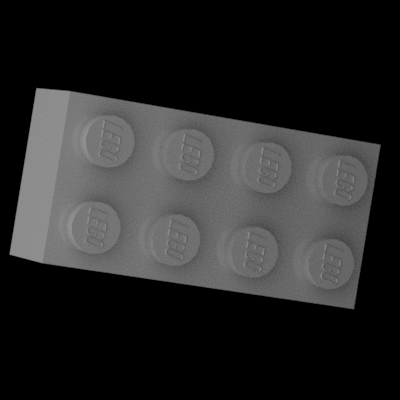

In [376]:
# Print a random image from the list to ensure the import was successful
images[500]

# Pre-processing Data

In [377]:
# Check the size of an image
images[400].size

(400, 400)

In [378]:
# Check the pixel values of images

print(np.array(images[400]).min(), np.array(images[400]).max())

0 152


In [379]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in images])
sizes

{(400, 400)}

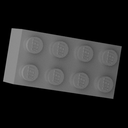

In [380]:
# Use a for loop to resize all images to 250 by 250
target_size = (128,128)

resized_images = [img.resize(target_size, resample = Image.LANCZOS) for img in images]
resized_images[500]

In [381]:
# Verify the resizing of all images
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in resized_images])
sizes

{(128, 128)}

In [ ]:
"""
kernel = np.ones((3, 3), np.uint8)

new_images = [np.array(img)  for img in resized_images]
edges=[cv2.Canny(img,50,150) for img in new_images]

dilated_edges = [cv2.dilate(img, kernel, iterations=1) for img in edges]
expanded_edges = [np.stack((img,) * 3, axis=-1) for img in dilated_edges]
batched_images = np.array(expanded_edges)
print("Batched Images Shape:", batched_images.shape)  # Check the shape


plt.figure(figsize=(8,6))
plt.imshow(batched_images[600], cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")
plt.show()
"""

'\nkernel = np.ones((3, 3), np.uint8)\n\nnew_images = [np.array(img)  for img in resized_images]\nedges=[cv2.Canny(img,50,150) for img in new_images]\n\ndilated_edges = [cv2.dilate(img, kernel, iterations=1) for img in edges]\nexpanded_edges = [np.stack((img,) * 3, axis=-1) for img in dilated_edges]\nbatched_images = np.array(expanded_edges)\nprint("Batched Images Shape:", batched_images.shape)  # Check the shape\n\n\nplt.figure(figsize=(8,6))\nplt.imshow(batched_images[600], cmap="gray")\nplt.title("Canny Edge Detection")\nplt.axis("off")\nplt.show()\n'

In [382]:
# Convert to NumPy array and then to float32


float_images = [np.array(img).astype(np.float32) for img in resized_images]
print("Pixel Values:")
print(np.array(float_images[700]).min(), np.array(float_images[700]).max())


Pixel Values:
0.0 146.0


In [383]:
# Normalize pixel values to range [0, 1]
normalized_images = [img/255 for img in float_images]
print("Pixel Values:")
print(np.array(normalized_images[700]).min(), np.array(normalized_images[700]).max())


Pixel Values:
0.0 0.57254905


In [ ]:
"""
# Invert the image for better feature extraction
inverted_images = [1 - img for img in normalized_images]
print(np.array(inverted_images[600]).min(), np.array(inverted_images[400]).max())
"""

0.3333333 1.0


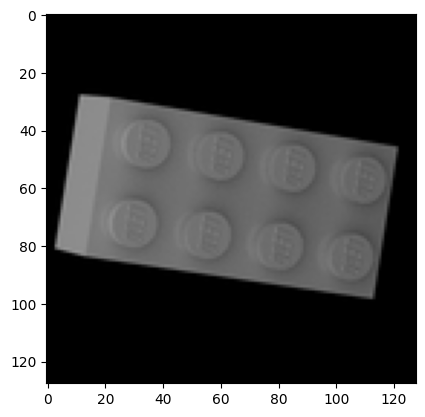

In [384]:
import matplotlib.pyplot as plt

# Display the image
plt.imshow(normalized_images[500])
plt.show()

In [385]:
#check the channel dimensions
normalized_images[400].shape

(128, 128, 3)

In [386]:
import tensorflow as tf

grayscale_images = tf.image.rgb_to_grayscale(normalized_images)


print(grayscale_images.shape)

(1136, 128, 128, 1)


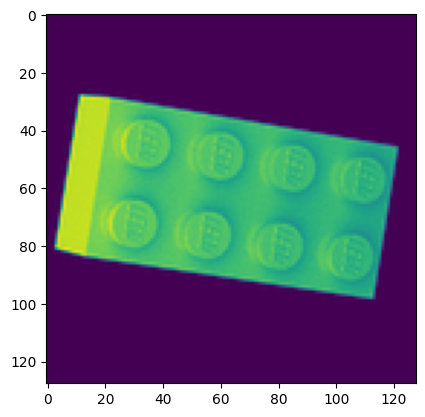

In [387]:
plt.imshow(grayscale_images[500])
plt.show()

# Labels

In [388]:
filename_df.head()

,filename
0,2357 brick corner 1x2x2 172R.png
1,3001 brick 2x4 171L.png
2,2357 brick corner 1x2x2 148L.png
3,3001 brick 2x4 159L.png
4,3001 brick 2x4 207R.png


In [389]:
# Function to handle different filename structures
def split_filename(filename):
    parts = filename.replace('.png', '').split()  # Remove .png if needed and split by space
    design_id = parts[0]  # First part is the design ID
    image_id = parts[-1]  # Last part is the image ID
    element_size = parts[-2]  # Second last part is the element size
    element_name = " ".join(parts[1:-2])  # Everything in between is the element name
    return pd.Series([design_id, element_name, element_size, image_id])


# Apply function to DataFrame
filename_df[['design_id', 'element_name', 'element_size', 'image_#']] = filename_df['filename'].apply(split_filename)


filename_df.head()

,filename,design_id,element_name,element_size,image_#
0,2357 brick corner 1x2x2 172R.png,2357,brick corner,1x2x2,172R
1,3001 brick 2x4 171L.png,3001,brick,2x4,171L
2,2357 brick corner 1x2x2 148L.png,2357,brick corner,1x2x2,148L
3,3001 brick 2x4 159L.png,3001,brick,2x4,159L
4,3001 brick 2x4 207R.png,3001,brick,2x4,207R


In [390]:
filename_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1136 entries, 0 to 1135
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   filename      1136 non-null   object
 1   design_id     1136 non-null   object
 2   element_name  1136 non-null   object
 3   element_size  1136 non-null   object
 4   image_#       1136 non-null   object
dtypes: object(5)
memory usage: 44.5+ KB


In [391]:
# Now we can call our preprocessed pixel data 'X'
X = grayscale_images

# For our purposes, we'll select the design_id column as 'y'
y = filename_df['design_id']

In [392]:
# Check the total number of classes
y.nunique()

4

In [393]:
# Get the actual class values
lego_classes = pd.Series(y).unique() # Convert y to a pandas Series
print(f"Lego Design Ids: {lego_classes}")

Lego Design Ids: ['2357' '3001' '3022' '3010']


In [394]:
y.shape

(1136,)

In [395]:
# Convert values to numpy arrays
X = np.array(X)
y = np.array(y)

In [396]:
X.shape, y.shape

((1136, 128, 128, 1), (1136,))

In [397]:
# Now we'll split our data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Checking if the length of training and testing data sets are same

In [398]:
# Print the length of each list
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

852
852
284
284


## Augmentation

In [399]:

# Apply augmentation to the whole training dataset
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip('horizontal'), # Random horizontal flip
    tf.keras.layers.RandomZoom(0.2),  # Random zoom (20%)
    tf.keras.layers.RandomTranslation(0.1, 0.1),

    #tf.keras.layers.RandomBrightness(0.2),
])

# Create variables to hold the X and y training data
X_train_aug = []
y_train_aug = []

# Loop through all the images.
for i in range(len(X_train)):
    img = X_train[i]
    label = y_train[i]

    # Add a channel dimension for grayscale images
    #img = np.expand_dims(img, axis=-1)  # Add channel dimension
    # Ensure that the input data has the correct shape
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Add 5 images for every original image
    for j in range(12):
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        y_train_aug.append(label)

# Print the length of each list
print(len(X_train_aug))
print(len(y_train_aug))



10224
10224


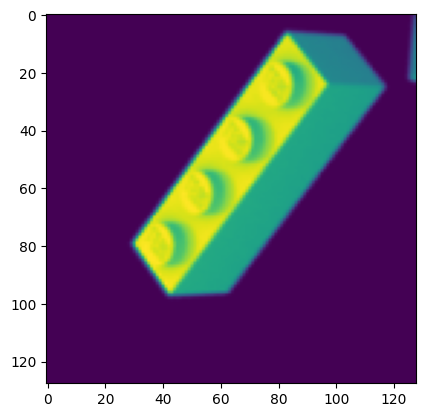

In [419]:
plt.imshow(X_train_aug[5040])

plt.show()

In [420]:
y_train_aug[600]



'3022'

In [421]:


# Reshape test data for the model
X_test_np = []
for img in X_test:
  # Add a channel dimension for grayscale images

    X_test_np.append(img)

# Convert to numpy array
X_test_np = np.array(X_test_np)

# Check the shape of the first image
X_test_np[0].shape



(128, 128, 1)

# Creating the CNN Model

In [422]:
#One hot encode the y data

y_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train_aug).reshape(-1, 1))
y_train_aug_enc = y_encoder.transform(np.array(y_train_aug).reshape(-1, 1))
y_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))


"\n\ny_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(np.array(y_train).reshape(-1, 1))\ny_train_enc = y_encoder.transform(np.array(y_train).reshape(-1, 1))\ny_test_enc = y_encoder.transform(np.array(y_test).reshape(-1, 1))\n"

In [423]:
# Convert values to numpy arrays

#Augmentation code
X_train_aug_np = np.array(X_train_aug)
X_test_np = np.array(X_test_np)
y_train_aug_np = np.array(y_train_aug_enc)
y_test_np = np.array(y_test_enc)



In [424]:
X_train_aug_np.shape

(10224, 128, 128, 1)

In [425]:
X_test_np.shape

(284, 128, 128, 1)

In [426]:
y_test_np.shape

(284, 4)

In [427]:
y_train_aug_np.shape

(10224, 4)

In [ ]:
#X_train_np = np.expand_dims(X_train_np[:, :, :, 0], axis=-1)
#X_test_np = np.expand_dims(X_test_np[:, :, :, 0], axis=-1)

In [428]:
# Split the training dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_aug_np, y_train_aug_np, test_size=0.3, random_state=42)

In [459]:
# Define a CNN model

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import AUC

model1 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',padding='same',input_shape=(128, 128, 1),kernel_regularizer=keras.regularizers.l2(0.00005)),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.4),

    layers.Conv2D(96, (3, 3), activation='relu',padding='same',kernel_regularizer=keras.regularizers.l2(0.00005)),
    #layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    #layers.Dropout(0.4),

    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=keras.regularizers.l2(0.00005)),
    #layers.BatchNormalization(),
    #layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),

    layers.Dense(4, activation='softmax')
])



# Set SGD Optimizer
#optimizer = SGD(learning_rate=0.001, momentum=0.9)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model

model1.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
#model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy',AUC()])


# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    patience=10,          # Number of epochs to wait for improvement before stopping
    restore_best_weights=True  # Restore the weights of the best epoch
)

# Train the model with the callback
history = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=35,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
# Evaluate the model using the testing data
model1.evaluate(X_test_np, y_test_np)



Epoch 1/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.2496 - loss: 1.4025 - val_accuracy: 0.2523 - val_loss: 1.3899
Epoch 2/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2634 - loss: 1.3906 - val_accuracy: 0.2507 - val_loss: 1.3887
Epoch 3/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2870 - loss: 1.3822 - val_accuracy: 0.2539 - val_loss: 1.3910
Epoch 4/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3644 - loss: 1.3266 - val_accuracy: 0.2539 - val_loss: 1.4463
Epoch 5/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5318 - loss: 1.0936 - val_accuracy: 0.2630 - val_loss: 1.5938
Epoch 6/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8353 - loss: 0.4817 - val_accuracy: 0.2611 - val_loss: 2.4072
Epoch 7/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9802 - loss: 0.0828 - val_accuracy: 0.2617 - val_loss: 4.4442
Epoch 8/35
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9961 - loss: 0.0235 - val_accuracy: 0

[5.8632330894470215, 0.26056337356567383]

## Model 1 Predictions and Evaluations

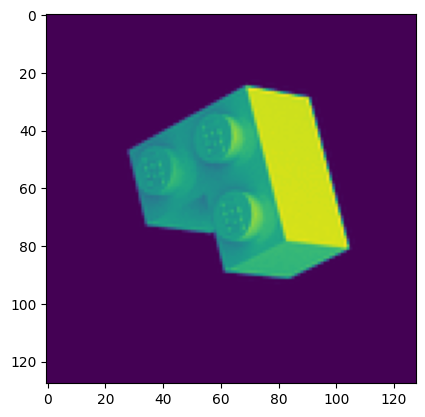

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Lego Brick ID 2357: 5.279%
Lego Brick ID 3001: 0.507%
Lego Brick ID 3022: 93.869%
Lego Brick ID 3010: 0.345%

Prediction Probabilities: [[0.05279306 0.00506628 0.93869454 0.00344611]]

Predicted Lego ID: 3022


In [444]:
# Make predictions

img_id = 280

input_image = X_test_np[img_id]

plt.imshow(X_test_np[img_id])
plt.show()

# Add a batch dimension:
input_image = input_image[np.newaxis, ...]  # Now shape is (1, 128, 128, 1)
prediction = model1.predict(input_image)
lego_class = np.argmax(prediction)   # Lego with high probability

for i, prob in enumerate(prediction[0]):
    percentage = prob * 100
    print(f"Lego Brick ID {lego_classes[i]}: {percentage:.3f}%")

#print(f"Test Brick ID: {unique_classes[100]}","Prediced Lego ID :", {unique_classes[predicted_class]})
print(f"\nPrediction Probabilities: {prediction}")
#print(f"Lego pieces list: {unique_classes}")
print(f"\nPredicted Lego ID: {lego_classes[lego_class]}")





9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2499 - loss: 5.9649 

Test Accuracy: 26.06%
Test Loss: 5.8632


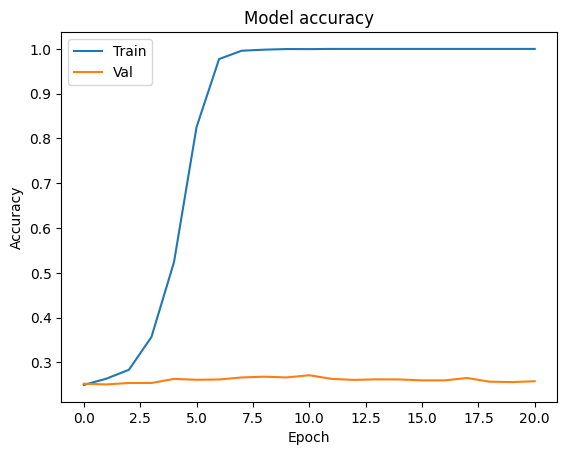

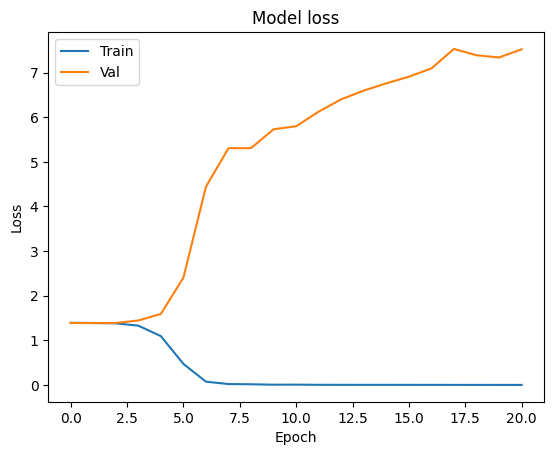

In [460]:
# Evaluate the model using the testing data
test_results= model1.evaluate(X_test_np, y_test_np)
print(f"\nTest Accuracy: {test_results[1]*100:.2f}%")
print(f"Test Loss: {test_results[0]:.4f}")


# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [307]:
from google.colab import drive
import pickle

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [308]:
model1.save('/content/drive/MyDrive/model1_trained.keras')  # Save model
#model = keras.models.load_model('/content/drive/MyDrive/model_checkpoint.keras')

In [138]:
model1.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 128, 128, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 30, 30, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,227,406 (42.83 MB)

 Trainable params: 3,742,468 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,484,938 (28.55 MB)

In [ ]:
model2.save('/content/drive/MyDrive/model2.keras')  #

## Simple Model

In [449]:
# Define a basic CNN model

from tensorflow.keras.initializers import HeNormal

model3 = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu',input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(4, activation='softmax')
])

# Compile the model
model3.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# Train the model with the callback
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping]  # Pass the EarlyStopping callback
)
"""
# Train the model
batch_size = 32
epochs = 20
history = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs
)
"""
# Evaluate the model using the testing data
model3.evaluate(X_test_np, y_test_np)


Epoch 1/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.2506 - loss: 1.3980 - val_accuracy: 0.2523 - val_loss: 1.3860
Epoch 2/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2683 - loss: 1.3856 - val_accuracy: 0.2546 - val_loss: 1.3854
Epoch 3/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2809 - loss: 1.3804 - val_accuracy: 0.2669 - val_loss: 1.3882
Epoch 4/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3235 - loss: 1.3613 - val_accuracy: 0.2689 - val_loss: 1.3896
Epoch 5/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3875 - loss: 1.3131 - val_accuracy: 0.2617 - val_loss: 1.4033
Epoch 6/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4776 - loss: 1.2133 - val_accuracy: 0.2565 - val_loss: 1.4690
Epoch 7/50
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6103 - loss: 0.9592 - val_accuracy: 0.2598 - val_loss: 1.7319
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2017 - loss: 1.3911 


[1.3918336629867554, 0.23943662643432617]

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2017 - loss: 1.3911 


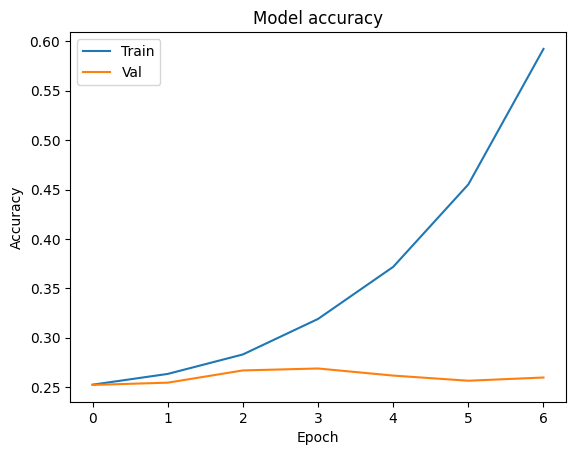

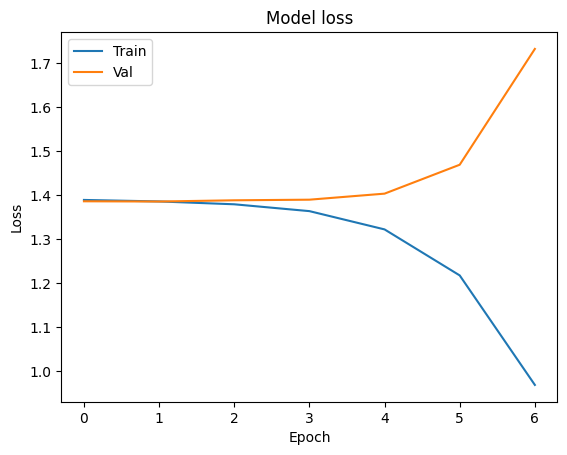

In [450]:
# Evaluate the model3 using the testing data
model3.evaluate(X_test_np, y_test_np)

# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [143]:
model3.save('/content/drive/MyDrive/model3_trained.keras')

In [178]:
from google.colab import files
uploaded = files.upload()

Saving 2357 brick corner 1x2x2 000L.png to 2357 brick corner 1x2x2 000L.png


In [179]:
#Plot the input image

import matplotlib.pyplot as plt

for file_name in uploaded.keys():
    print("Uploaded file:", file_name)

    # Read the image using OpenCV
    image = cv2.imread(file_name)  # This reads the image in default BGR format


Uploaded file: 2357 brick corner 1x2x2 000L.png


In [182]:
processed_input = np.array(image_with_channel1)

## Model1 - Basic CNN model prediction

In [183]:
# Add a batch dimension to image_with_channel1
processed_input = np.expand_dims(processed_input, axis=0)


predict_img1 = model1.predict(processed_input)
predicted_class = np.argmax(predict_img1)  # Get class index
print(predict_img1)
print(f"Lego pieces: {unique_classes}")
print (f"Predicted Lego Id: {unique_classes[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[4.2705819e-02 9.5729190e-01 3.5892824e-09 2.2683168e-06]]
Lego pieces: ['2357' '3001' '3022' '3010']
Predicted Lego Id: 3001


## Model3 - Simple model prediction

In [166]:
from collections import Counter

# Add a batch dimension to image_with_channel1
#image_with_channel1 = np.expand_dims(image_with_channel1, axis=0)

predict_img1 = model3.predict(image_with_channel1)
predicted_class = np.argmax(predict_img1)  # Get class index
print(predict_img1)
print(predicted_class)
print(f"Lego pieces: {unique_classes}")
print (f"Predicted Lego Id: {unique_classes[predicted_class]}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[[2.5941353e-04 9.8086458e-01 3.6315208e-13 1.8875895e-02]]
1
Lego pieces: ['2357' '3001' '3022' '3010']
Predicted Lego Id: 3001


## Hyperparamter tuning - Random search

In [ ]:

!pip install keras-tuner -q

import keras
from keras import layers
from keras_tuner import HyperModel, RandomSearch
import tensorflow as tf

# Define a model using HyperModel (used for hyperparameter tuning)
class CNNHyperModel(HyperModel):
    def build(self, hp):
        # Create a Sequential model
        model3 = keras.Sequential()

        # Hyperparameters for Conv2D layers
        model3.add(layers.Conv2D(
            filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=(224, 224, 3)
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.MaxPooling2D((2, 2)))

        model3.add(layers.Conv2D(
            filters=hp.Int('conv_3_filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3),
            activation='relu'
        ))
        model3.add(layers.Flatten())

        # Hyperparameter for Dense layer
        model3.add(layers.Dense(
            units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
            activation='relu'
        ))

        # Output layer
        model3.add(layers.Dense(4, activation='softmax'))  # Binary classification

        # Compile the model
        model3.compile(
            optimizer=keras.optimizers.Adam(),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model3


# Instantiate the HyperModel
cnn_hypermodel = CNNHyperModel()

# Define the hyperparameter search
tuner = RandomSearch(
    cnn_hypermodel,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_trials=5,               # Number of different hyperparameter combinations to test
    executions_per_trial=3,     # How many times to train each model
    directory='tuner_dir',      # Directory to save the results
    project_name='cnn_batch_tuning'  # Project name
)

# Perform the hyperparameter search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)

# Get the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on the test data
best_model.evaluate(X_test_np, y_test_np)





Trial 5 Complete [00h 10m 02s]
val_accuracy: 0.32159624497095746

Best val_accuracy So Far: 0.3262910743554433
Total elapsed time: 00h 52m 41s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.2171 - loss: 6.6949


[6.253284454345703, 0.23591549694538116]

In [ ]:

# Print best hyperparameters
print("Best Hyperparameters Found:")
for param in best_hyperparameters.values:  # Use best_hyperparameters instead of best_hps
    print(f"{param}: {best_hyperparameters.get(param)}")

Best Hyperparameters Found:
conv_1_filters: 32
conv_2_filters: 128
conv_3_filters: 128
dense_units: 128


In [ ]:
# Since it's binary classification, check if the probability for class 1 is > 0.5
predicted_class = (predict_img1 > 0.5).astype(int)  # Convert to 0 or 1 based on the threshold

# Print the predicted class
print(f"Predicted class for the image: {predicted_class[0][0]}")

prob_class_0 = predict_img1[0][0]  # Probability for class 0
print(f"Probability of being a LEGO piece (Class 0): {prob_class_0}")

#Gradio application code

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 126.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  espeak-data libespeak1 libportaudio2 libsonic0
The following NEW packages will be installed:
  espeak espeak-data libespeak1 libportaudio2 libsonic0
0 upgraded, 5 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,382 kB of archives.
After this operation, 3,178 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe am

In [463]:
# Import Gradio
import gradio as gr
import pyttsx3



In [464]:
#Initialize the TTS engine
engine=pyttsx3.init()

#Funciton to convert text to speech
def text_to_speech(text):
    engine.save_to_file(text,"output.wav")
    engine.runAndWait()
    return "output.wav"

In [517]:
import cv2
# Process the input image
def process_image(img):
  lego_classes = ['2357', '3001', '3022', '3010']

  numpy_image = np.array(img)  # Convert PIL Image to NumPy array

  #Convert image to grayscale
  grayscale_image = cv2.cvtColor(numpy_image, cv2.COLOR_BGR2GRAY)
  resized_image = cv2.resize(grayscale_image, (128, 128))  # Resize to desired dimensions

  #Pre-process the image
  float_image = np.array(resized_image).astype(np.float32)
  normalized_image = float_image / 255.0


  #Add channel and batch dimensions
  #image_with_channel = np.expand_dims(normalized_image, axis=0)
  image_with_channel1 = np.expand_dims(normalized_image, axis=-1)
  #print("Grayscale Image Shape:", image_with_channel1.shape)
  processed_input = np.expand_dims(image_with_channel1, axis=0)

  #Predict the image through model
  predict_image= model1.predict(processed_input)
  predicted_class = np.argmax(predict_image)  # Get class index
  print(predicted_class)
  # Add the lego record in dictionary
  probability_lines=[]
  probs = predict_image[0]
  probability_lines = [
        f"Lego Brick ID {lego_classes[i]}: {prob * 100:.2f}%"
        for i, prob in enumerate(probs)
    ]
  probabilities_text = "\n".join(probability_lines)

  #spoken_text = "The Lego probabilities are: "
  #for i in range(4):
        #spoken_text += f"Lego ID {lego_classes[i]} with probability {probs[i]*100:.1f} percent. "

  #engine.say(spoken_text)
  #engine.runAndWait()

  info_text = f"Predicted LEGO Brick: {lego_classes[predicted_class]}"
  #info_text = text_to_speech(probabilities_text)

  return probabilities_text, info_text


In [518]:
app = gr.Interface(
    fn=process_image,  # Function to call
    inputs=gr.Image(type="pil"),  # Input type (image)
    outputs=[
              gr.Textbox(label="Lego probability"),
              gr.Textbox(label="Give me an interesting fact about the Legoes")
              ],  #
    title="LEGO Type Classifier",
    description="Upload an image of a LEGO brick to classify its type and get more information about it."
)


In [519]:
app.launch(debug=True)

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://042dc577cea13e278d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
0
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7868 <> https://042dc577cea13e278d.gradio.live
